# PINN for Uniform Rectilinear Motion

## Importing Necessary Packages

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
from matplotlib import pyplot as plt


## Determining Equation of Motion

Below a Python function is developed to facilitate the development of our mathematical function, which afterwards will be used to define the network's loss function.   

Given we are dealing with a Uniform Rectilinear Motion (URM), the differential equation is given by

\begin{equation}
    \dfrac{dx}{dt} - v = 0,
\end{equation}

with boundary condition given by

\begin{equation*}
    x(t=0) = 10
\end{equation*}

where $x$ refers to a temporal function of position, $t$ to time and $v$ to a constant velocity. Basically, this equation describes the movement of a body with constant velocity.

For the purpose of this study, the domains considered will be

\begin{equation*}
    t \in \left[ 0,1 \right]
\end{equation*}

and

\begin{equation*}
    v = 2.
\end{equation*}

## Network's Architecture

In the following cell, we define the archictecture's hyperparameters, note that the activation function applied here is a hyperbolic tangent (Tanh) for it being non-linear and ranging from -1 to 1. It is also interesting to pay attention to the fact that we are building the linear neural network from scratch due the lack of a PyTorch module specific for it, i.e., we are building a custom module.

In [84]:
class LinearNN(nn.Module):
    def __init__(
            self,
            num_inputs: int=1,
            num_layers: int=5,
            num_neurons: int=11,
            act: nn.Module = nn.Tanh()
    ) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # Input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # Hidden layers
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # Output layers
        layers.append(nn.Linear(num_neurons, 1))

        # Building the network as sequential
        self.network = nn.Sequential(*layers)

    # Setting up the output
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1,1)).squeeze()

## Loss Function

Here the loss function for our network will be defined, we begin by defining the initial conditions $x0 = x(t=0) = 10$ and $v=2$, afterwards a tensor of 100 elements is defined to receive the possible temporal coordinates that the model may assume. Considering the initial conditions established and the temporal tensor,  it is now possible to define a function that returns the position $x$ at a given time.

In [85]:
# Random list of 100 temporal cordinates in 1D
t = torch.rand(100, 1)

# Position coordinate of a border
x0 = 10
# Velocity
v = 2

def x_analytical(t):
   return x0 + v*t

Finally, the model and training data are created, hence providing enough resources to define the loss function itself, which is defined by applying the model to the temporal training data (generating thereafter the $x_pred$ variable), the loss will also consider the temporal derivative of the position predicted thus it is also computed.

In conclusion, the loss function will return the mean squared error between the predicted and actual values through two different methods. The first method considers equation (1) whilst substituing the first term by the one predicted by the model. As for the second method, it considers de position provided by the model against the analytical result.

In [86]:
# Running the structure created
model = LinearNN()

# Parameters for training
t_train = torch.rand(100,1, requires_grad =True)

x_analytic = x_analytical(t_train)

# Loss function
def loss_fn(model, t_train):

    x_pred = model(t_train)
    xt_train_dot = grad(x_pred, t_train, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0][:,0]

    return torch.mean(torch.square(xt_train_dot - v))  + torch.mean(torch.square(x_pred - x_analytic))

## Model Training

In this section, the model is being trained along 1000 cycles (epochs) through the Adam optimizer at a learning rate of 0.001. One may note that a gradient descent is applied and the graph is being retained for later analysis. It is also shown the evolution of the loss at each cycle.

In [87]:
epochs = 1000

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):

    optimizer.zero_grad()

    loss = loss_fn(model, t_train)
    loss.backward(retain_graph=True)
    optimizer.step()

    print(f"Epoch {epoch} with loss {float(loss)}") 

Epoch 0 with loss 125.00753784179688
Epoch 1 with loss 124.69764709472656
Epoch 2 with loss 124.3872299194336
Epoch 3 with loss 124.07585144042969
Epoch 4 with loss 123.76353454589844
Epoch 5 with loss 123.45028686523438
Epoch 6 with loss 123.13609313964844
Epoch 7 with loss 122.82093048095703
Epoch 8 with loss 122.50476837158203
Epoch 9 with loss 122.18753051757812
Epoch 10 with loss 121.86917114257812
Epoch 11 with loss 121.54960632324219
Epoch 12 with loss 121.22879028320312
Epoch 13 with loss 120.90658569335938
Epoch 14 with loss 120.58293151855469
Epoch 15 with loss 120.25769805908203
Epoch 16 with loss 119.93074035644531
Epoch 17 with loss 119.60188293457031
Epoch 18 with loss 119.27091217041016
Epoch 19 with loss 118.93758392333984
Epoch 20 with loss 118.60157012939453
Epoch 21 with loss 118.26255798339844
Epoch 22 with loss 117.92015075683594
Epoch 23 with loss 117.57402801513672
Epoch 24 with loss 117.22380828857422
Epoch 25 with loss 116.8691177368164
Epoch 26 with loss 116.5

Epoch 116 with loss 73.10298156738281
Epoch 117 with loss 72.74535369873047
Epoch 118 with loss 72.39139556884766
Epoch 119 with loss 72.04104614257812
Epoch 120 with loss 71.69422912597656
Epoch 121 with loss 71.35089874267578
Epoch 122 with loss 71.010986328125
Epoch 123 with loss 70.6744384765625
Epoch 124 with loss 70.3412094116211
Epoch 125 with loss 70.01123046875
Epoch 126 with loss 69.68443298339844
Epoch 127 with loss 69.36080169677734
Epoch 128 with loss 69.04024505615234
Epoch 129 with loss 68.72271728515625
Epoch 130 with loss 68.40818786621094
Epoch 131 with loss 68.09657287597656
Epoch 132 with loss 67.78784942626953
Epoch 133 with loss 67.48193359375
Epoch 134 with loss 67.1788101196289
Epoch 135 with loss 66.87840270996094
Epoch 136 with loss 66.58068084716797
Epoch 137 with loss 66.28559112548828
Epoch 138 with loss 65.99308013916016
Epoch 139 with loss 65.70310974121094
Epoch 140 with loss 65.41564178466797
Epoch 141 with loss 65.13059997558594
Epoch 142 with loss 64.

## Analysis of Perfomance

Finally, an analysis of the model performance is developed through visualization of its learning evolution in time. In the following graph, it is seen that the maintains a constant prediction for all coordinate points what is accordance to the movement described. Besides such behaviour, the graph also shows that the difference between the analytical and predicted values is smaller than 0.25, implying the model performed well.

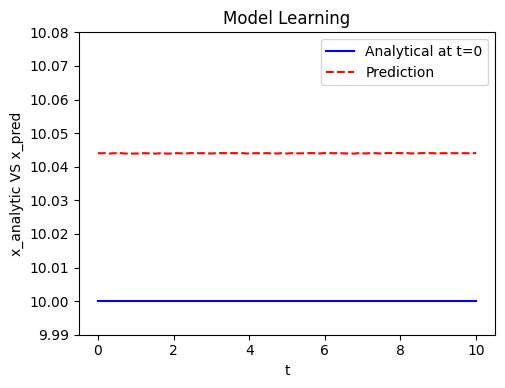

In [96]:
x_plot = np.linspace(0, 10, 100)
t_plot = np.zeros_like(x_plot)
x_pred = model(t).cpu().detach().numpy()
mean_p = np.mean(x_pred)

fig, ax = plt.subplots()
ax.set_ylim(9.99, 10.08)
plt.subplots_adjust(left=0.25, bottom=0.25)
l, = plt.plot(x_plot, x_analytical(t_plot), 'b', label='Analytical at t=0')
p, = plt.plot(x_plot, x_pred, '--r', label='Prediction')
# ax.hlines(mean_p, xmin=0, xmax=10, color='g', linestyle='-', label='Mean of Prediction')
plt.title('Model Learning')
plt.xlabel('t')
plt.ylabel('x_analytic VS x_pred')
plt.legend(loc='upper right');